## Phys 704 Final Project

 ##### Name: Michael Bouliane 
 ##### ID: 20801403

## Setting Up Ising Model Class

Ising hamiltonian defined as:

$$ H = -J\sum_{\langle i,j \rangle} \sigma_{i} \sigma_{j} $$

Where $J=1$ and $\sigma_{i} = \pm 1$. Lattice is a square lattice of size $L \times L$, where spins are initialized in random configurations.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class IsingSystem():
    def __init__(self,T=1.,L=5):
        '''Initializes an Ising lattice of size LxL with reciprocal temperature T'''
        
        self.temp = T
        self.lattice_size = L

        self.lattice = np.random.choice((-1,1), size=(self.lattice_size, self.lattice_size))
    
    def energy(self,idx):
        '''Computes the energy of a single spin site at given location
        
        Args:
        idx: Site index of spin

        Returns:
        E: Energy of site computed with Ising hamiltonian'''

        site = self.lattice[idx]

        left = (idx[0], idx[1]-1)
        right = (idx[0], (idx[1]+1)%self.lattice_size)
        top = (idx[0]-1, idx[1])
        bottom = ((idx[0]+1)%self.lattice_size, idx[1])

        E = -site*sum((self.lattice[left], self.lattice[right], self.lattice[top], self.lattice[bottom]))
        
        return(E)

    def magnetization(self):
        
        M = np.sum(self.lattice)
        M /= self.lattice_size**2

        return(abs(M))
    
    def energy_per_site(self):
        E = 0.

        for i in range(self.lattice_size):
            for j in range(self.lattice_size):
                E += self.energy((i,j))
        
        E /= self.lattice_size**2

        return(E)

    def metropolis(self, steps, accept_prob):

        steps = int(steps)
        accept_steps = int(accept_prob*steps)
                
        idxs = np.random.randint(0,self.lattice_size,(steps,2)) #random sites for spin flips
        probs = np.random.random(size=steps) #array of acceptance probabilities

        energy_array = np.zeros(steps)
        energy = 0.
        energy2 = 0.
        ei = self.energy_per_site()

        mag_array = np.zeros(steps)
        mag = 0.
        mag2 = 0.
        mi = 0.

        for i in range(steps):
            idx = tuple(idxs[i,:])
            energy_init = self.energy(idx)
            energy_final = -energy_init

            dE = energy_final-energy_init

            # if final state is lower in energy, accept the spin flip
            if dE <= 0: 
                self.lattice[idx] = -self.lattice[idx]
                ei += dE/self.lattice_size**2

            else:
                boltz_fact = np.exp(-dE/self.temp) #boltzmann weight of energy difference

                # accept the spin flip that increases energy if boltzmann weight > acceptance prob
                if probs[i]<boltz_fact:
                    self.lattice[idx] = -self.lattice[idx]
                    ei += dE/self.lattice_size**2
        
            mi = self.magnetization()
            
            energy_array[i] = energy_array[i] + ei
            mag_array[i] = mi

            if i >= accept_steps:
                energy += ei
                energy2 += ei * ei
                mag += mi
                mag2 += mi * mi

        return(energy_array, 
            energy/(steps-accept_steps),
            energy2/(steps-accept_steps),
            mag_array, 
            mag/(steps-accept_steps),
            mag2/(steps-accept_steps)
            )
    
    def heat_cycle(self, steps, accept_prob, T_start, T_fin, len_T):
        
        temps = np.flip(np.linspace(T_start, T_fin, len_T))
        
        energy = np.zeros(len_T)
        energy2 = np.zeros(len_T)

        mag = np.zeros(len_T)
        mag2 = np.zeros(len(temps))

        for T in range(len_T):
            self.temp = temps[T]
            _, energy[T], energy2[T], _, mag[T], mag2[T] = self.metropolis(steps, accept_prob)
        
        return(energy, energy2, mag, mag2, temps)
    
    def finite_scale(self):
        Ls = [12, 16, 20, 24]
        chi = []

        for i in range(4):
            self.__init__(1, Ls[i])
            _, _, m, m2, T = self.heat_cycle(1e6, 0.1, 1, 3, 60)
            chi.append(self.lattice_size**2*(m2-m*m)/T)

        return(chi, T)           

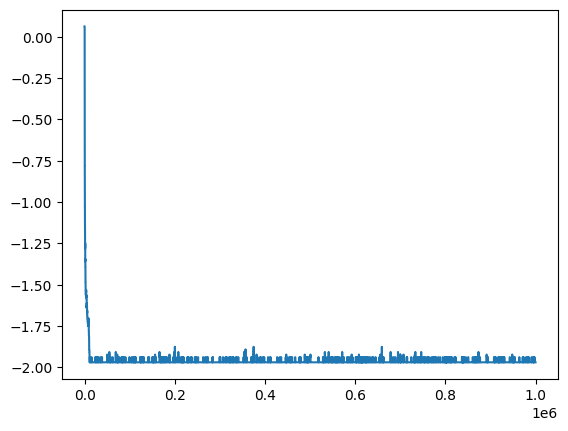

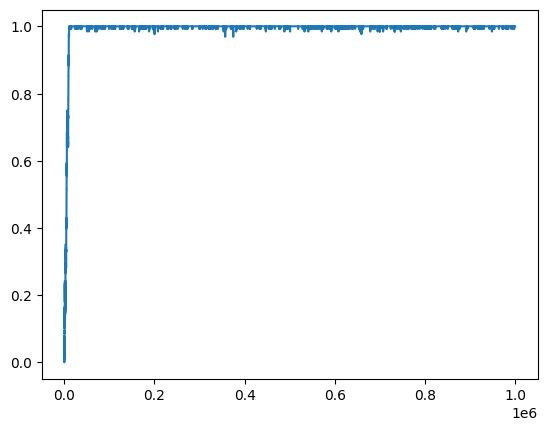

In [16]:
test = IsingSystem(1, 16)

energy, e, e2, mag, m, m2 = test.metropolis(1e6, 0.1)

plt.plot(energy)
plt.show()

plt.plot(mag)
plt.show()

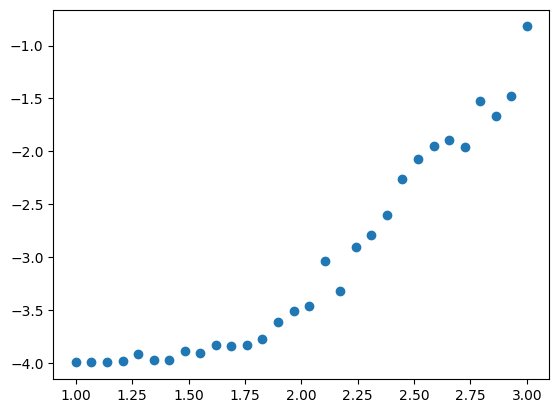

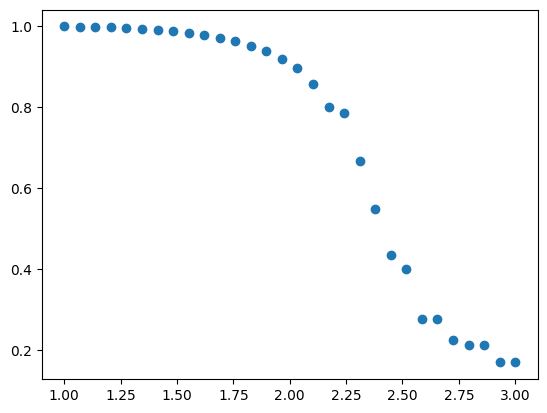

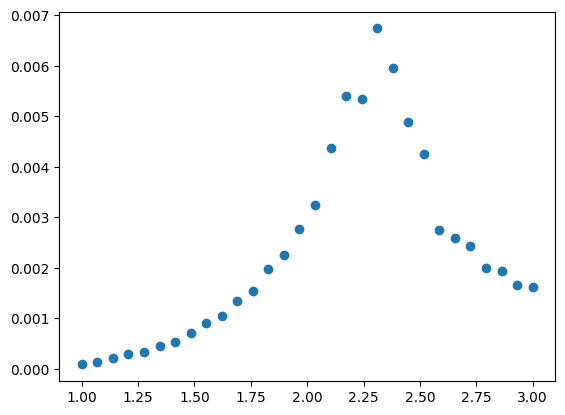

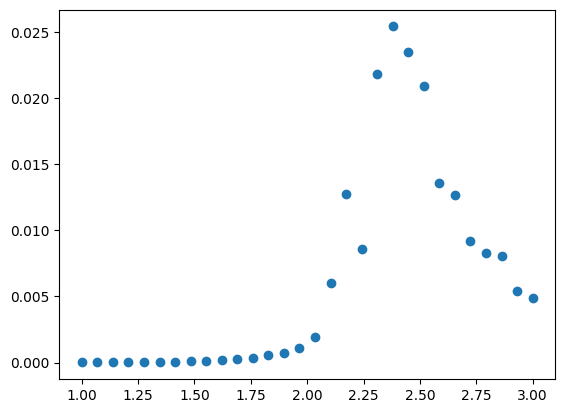

In [9]:
test2 = IsingSystem(1, 16)

e, e2, m, m2, T = test2.heat_cycle(1e6, 0.1, 1, 3, 30)

plt.scatter(T, e)
plt.show()

plt.scatter(T, m)
plt.show()

plt.scatter(T, (e2-e*e)/T**2)
plt.show()

plt.scatter(T, (m2-m*m)/T)
plt.show()

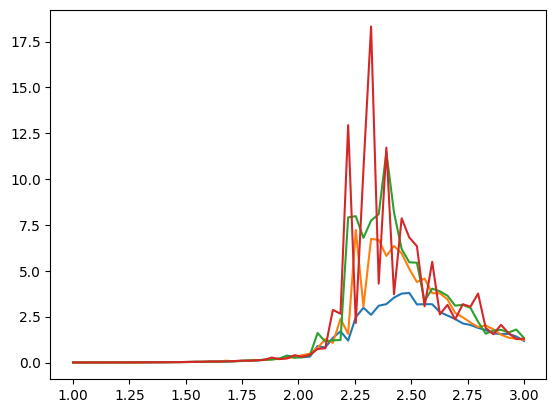

In [18]:
test3 = IsingSystem(1, 16)

chi, T = test3.finite_scale()

for i in range(4):
    plt.plot(T, chi[i])
plt.show()

## Update heatcycle code for higher data density between 2 and 3, and sparser data outside that range

## Sample total energy after 100 or 1000 etc MC steps to get uncorrelated measurements => better statistics 
## 